## Data Source : https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis


In [73]:
conda install seaborn

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes
import pickle

from datetime import datetime
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

## Import Data


In [75]:
market_df = pd.read_csv('../data/marketing_campaign.csv')
market_df.shape

(2240, 29)

## Explore data
- Transform cols
- Drop cols


In [76]:
market_df.head(2)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0


In [77]:
# Change birth year to age, customer date to years

def years_customer(inp_date):
    format_Dt = pd.to_datetime(inp_date, format="%d-%m-%Y")
    today = datetime.today()
    return today.year - format_Dt.year - ((today.month, today.day) < (format_Dt.month, format_Dt.day))

market_df['Yrs_Customer'] = market_df['Dt_Customer'].apply(lambda x: years_customer(x))

market_df['age'] = 2022 - market_df['Year_Birth']

#market_df.head(2)


In [78]:
# drop age outliers
#market_df.drop(market_df[ (market_df['age'] >= 80) & (market_df['age'] <= 0)].index, inplace = True)

# drop non-needed cols
market_df.drop(columns=['Z_CostContact','Z_Revenue','Dt_Customer','Year_Birth'], inplace=True)

# market_df.head(2)

In [79]:
# Trying to standardize these cols individually with Standard Scalar causes divide by 0 exceptions, bcz some values are 0
# 0 values causes -ve std dev looks like, and log -ve is inf. So getting a total of all spending here.

market_df['Total_Spent'] = market_df['MntWines'] + market_df['MntFruits'] +market_df['MntMeatProducts'] + market_df['MntFishProducts'] +market_df['MntSweetProducts'] + market_df['MntGoldProds']

In [80]:
print('\n',market_df[['Total_Spent']].agg(['mean','median','min','max', 'std']))
print('\n',market_df[['Income']].agg(['mean','median','min','max', 'std']))
print('\n',market_df[['Total_Spent']].value_counts())


         Total_Spent
mean     605.798214
median   396.000000
min        5.000000
max     2525.000000
std      602.249288

                Income
mean     52247.251354
median   51381.500000
min       1730.000000
max     666666.000000
std      25173.076661

 Total_Spent
46             19
22             18
57             16
44             15
55             15
               ..
1298            1
639             1
638             1
635             1
5               1
Length: 1054, dtype: int64


In [81]:
market_df.drop(columns=['MntWines','MntFruits','MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds'], inplace=True)

In [82]:
print('\n',market_df[['NumDealsPurchases']].value_counts())
print('\n',market_df[['NumWebPurchases']].value_counts())
print('\n',market_df[['NumCatalogPurchases']].value_counts())
print('\n',market_df[['NumStorePurchases']].value_counts())
print('\n',market_df[['NumWebVisitsMonth']].value_counts())



 NumDealsPurchases
1                    970
2                    497
3                    297
4                    189
5                     94
6                     61
0                     46
7                     40
8                     14
9                      8
15                     7
11                     5
10                     5
12                     4
13                     3
dtype: int64

 NumWebPurchases
2                  373
1                  354
3                  336
4                  280
5                  220
6                  205
7                  155
8                  102
9                   75
0                   49
11                  44
10                  43
27                   2
25                   1
23                   1
dtype: int64

 NumCatalogPurchases
0                      586
1                      497
2                      276
3                      184
4                      182
5                      140
6                      128
7    

In [83]:
market_df["Teenhome"] = np.where(market_df["Teenhome"] > 0, 1, 0)
market_df["Kidhome"] = np.where(market_df["Kidhome"] > 0, 1, 0)

In [84]:

print('\n',market_df[['NumDealsPurchases']].agg(['mean','median','min','max', 'std']))


         NumDealsPurchases
mean             2.325000
median           2.000000
min              0.000000
max             15.000000
std              1.932238


In [85]:
# Cannot standardize these cols again bcz 0 values cause divide by 0 error in Standard Scalar - summing them into an aggregate and then standardizing
# what happens if I drop the values entirely - might need investigation

In [86]:
# target Variable : Response - Results are not exactly 50-50 but we still proceed.
print(market_df[['Response']].value_counts())

Response
0           1906
1            334
dtype: int64


In [87]:
# Continuous Vars
print('\n',market_df[['Income']].agg(['mean','median','min','max', 'std']))
print('\n',market_df[['age']].agg(['mean','median','min','max', 'std']))
print('\n',market_df[['Yrs_Customer']].agg(['mean','median','min','max', 'std']))



                Income
mean     52247.251354
median   51381.500000
min       1730.000000
max     666666.000000
std      25173.076661

                age
mean     53.194196
median   52.000000
min      26.000000
max     129.000000
std      11.984069

         Yrs_Customer
mean        8.345089
median      8.000000
min         7.000000
max         9.000000
std         0.603046


In [88]:
# categorical variables
print('\n',market_df[['Education']].value_counts())
print('\n',market_df[['Marital_Status']].value_counts())


 Education 
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
dtype: int64

 Marital_Status
Married           864
Together          580
Single            480
Divorced          232
Widow              77
Alone               3
YOLO                2
Absurd              2
dtype: int64


In [89]:
market_df.replace("2n Cycle", "Unknown", inplace=True)
market_df.replace("Alone", "Single", inplace=True)
market_df.replace("Absurd", "Unknown", inplace=True)
market_df.replace("YOLO", "Unknown", inplace=True)

print('\n',market_df[['Education']].value_counts())
print('\n',market_df[['Marital_Status']].value_counts())


 Education 
Graduation    1127
PhD            486
Master         370
Unknown        203
Basic           54
dtype: int64

 Marital_Status
Married           864
Together          580
Single            483
Divorced          232
Widow              77
Unknown             4
dtype: int64


## Data Cleaning
- drop all Nulls



In [90]:
market_df.isnull().sum()

ID                      0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Recency                 0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
Yrs_Customer            0
age                     0
Total_Spent             0
dtype: int64

In [91]:
market_df.dropna(inplace=True)
market_df.reset_index(drop=True, inplace=True)
market_df.head(2).T

,0,1
ID,5524,2174
Education,Graduation,Graduation
Marital_Status,Single,Single
Income,58138,46344
Kidhome,0,1
Teenhome,0,1
Recency,58,38
NumDealsPurchases,3,2
NumWebPurchases,8,1
NumCatalogPurchases,10,1


# Visualize figure
- graph

In [92]:
# plotly visualization of Loan Status
import plotly.graph_objects as go

# remove a few outliers & split
responded=market_df[(market_df['Total_Spent']>1000) & (market_df['Income']>25000) & (market_df['Response']==1)]
ignored=market_df[(market_df['Total_Spent']<1000) & (market_df['Income']<25000) & (market_df['Response']==0)]

trace0=go.Scatter3d(
    x=responded['Income'],
    y=responded['Total_Spent'],
    z=responded['Recency'],
    name='responded',
    mode='markers',
    text = list(zip(
            ["Marital Status: {}".format(x) for x in market_df['Marital_Status']],
            ["Education: {}".format(x) for x in market_df['Education']],
            ["Yrs_Customer: {}".format(x) for x in market_df['Yrs_Customer']],
            ["Age: {}".format(x) for x in market_df['age']],
            ["Kid Home: {}".format(x) for x in market_df['Kidhome']],
            ["Teen Home: {}".format(x) for x in market_df['Teenhome']]
            )) ,
    hoverinfo='text',
    marker=dict(size=5, color='blue', opacity=0.4))

trace1=go.Scatter3d(
    x=ignored['Income'],
    y=ignored['Total_Spent'],
    z=ignored['Recency'],
    name='ignored',
    mode='markers',
    text = list(zip(
            ["Marital Status: {}".format(x) for x in market_df['Marital_Status']],
            ["Education: {}".format(x) for x in market_df['Education']],
            ["Yrs_Customer: {}".format(x) for x in market_df['Yrs_Customer']],
            ["Age: {}".format(x) for x in market_df['age']],
            ["Kid Home: {}".format(x) for x in market_df['Kidhome']],
            ["Teen Home: {}".format(x) for x in market_df['Teenhome']]
            )) ,
    hoverinfo='text',
    marker=dict(size=5, color='red', opacity=0.4))

layout = go.Layout(title="Response to Market Campaign",
                    showlegend=True,
                        scene = dict(
                        xaxis=dict(title='Income'),
                        yaxis=dict(title='Total Spent'),
                        zaxis=dict(title='Recency')
                ))
fig=go.Figure([trace0, trace1], layout)

fig

In [93]:
# save the figure for later use
fig.write_json('../model_components/response_cube-figure.json')

## Categorical variables
- One hot encoding: Marital_Status & Education
- Standardize other values

In [94]:
encoder1=OneHotEncoder()
ohe1=pd.DataFrame(encoder1.fit_transform(market_df[['Education']]).toarray())
col_list1 = ['Education_{}'.format(item) for item in market_df['Education'].value_counts().index]
ohe1.columns=col_list1
market_df = pd.concat([market_df, ohe1],axis=1)

In [95]:
encoder2=OneHotEncoder()
ohe2=pd.DataFrame(encoder2.fit_transform(market_df[['Marital_Status']]).toarray())
col_list2 = ['Marital_Status_{}'.format(item) for item in market_df['Marital_Status'].value_counts().index]
ohe2.columns=col_list2
market_df = pd.concat([market_df, ohe2],axis=1)

In [96]:
market_df.head(2).T

,0,1
ID,5524,2174
Education,Graduation,Graduation
Marital_Status,Single,Single
Income,58138,46344
Kidhome,0,1
Teenhome,0,1
Recency,58,38
NumDealsPurchases,3,2
NumWebPurchases,8,1
NumCatalogPurchases,10,1


## Standardize / Normalize 
- Not sure why we need to do the log
- Having the log causes issues when data points are 0

In [97]:
test_df = market_df

In [98]:
ss_scaler0 = StandardScaler()
test_df['ln_age'] = ss_scaler0.fit_transform(np.array(np.log(test_df['age'])).reshape(-1, 1))

ss_scaler1 = StandardScaler()
test_df['ln_Income'] = ss_scaler1.fit_transform(np.array(np.log(test_df['Income'])).reshape(-1, 1)) 


In [99]:


test_df.loc[test_df["Recency"] == 0, "Recency"] = 999
arr=np.log(test_df['Recency'])

ss_scaler2 = StandardScaler()
test_df['ln_Recency'] = ss_scaler2.fit_transform(np.array(arr).reshape(-1, 1))

ss_scaler3 = StandardScaler()
test_df['ln_Spending'] = ss_scaler3.fit_transform(np.array(np.log(test_df['Total_Spent'])).reshape(-1, 1))

ss_scaler30 = StandardScaler()
test_df['ln_Yrs_Customer'] = ss_scaler30.fit_transform(np.array(np.log(test_df['Yrs_Customer'])).reshape(-1, 1))

In [100]:

ss_scaler4 = StandardScaler()
test_df['ln_deals'] = ss_scaler4.fit_transform(np.array(test_df['NumDealsPurchases']).reshape(-1, 1))

ss_scaler40 = StandardScaler()
test_df['ln_web'] = ss_scaler40.fit_transform(np.array(test_df['NumWebPurchases']).reshape(-1, 1))

ss_scaler41 = StandardScaler()
test_df['ln_catalog'] = ss_scaler41.fit_transform(np.array(test_df['NumCatalogPurchases']).reshape(-1, 1))

ss_scaler42 = StandardScaler()
test_df['ln_store'] = ss_scaler42.fit_transform(np.array(test_df['NumStorePurchases']).reshape(-1, 1))

ss_scaler43 = StandardScaler()
test_df['ln_visits'] = ss_scaler43.fit_transform(np.array(test_df['NumWebVisitsMonth']).reshape(-1, 1))


In [101]:
test_df = test_df.dropna()

In [102]:
dropit=['Education', 'Marital_Status', 'Income', 'Recency', 'NumDealsPurchases', 'age', 'Total_Spent',
        'NumWebPurchases','NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth', 'ID', 'Complain', 'Yrs_Customer',
       'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4']
test_df.drop(columns=dropit, inplace=True)

In [103]:
test_df.head(12).T

,0,1,2,3,4,5,6,7,8,9,10,11
Kidhome,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
Teenhome,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
AcceptedCmp5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Response,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
Education_Graduation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Education_PhD,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Education_Master,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Education_Unknown,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
Education_Basic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Marital_Status_Married,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000


## Model Evaluation

In [104]:
def mod_eval(df,predictions, y_test, title):
    # prints confusion matrix heatmap    
    cm = confusion_matrix(df['Response'][y_test.index], predictions)
    sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes']).set_title(title)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    
    print(classification_report(df['Response'][y_test.index], predictions))

In [105]:
# train-test split
X=test_df.drop(columns=['Response'])
y=test_df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                     test_size=.3,
                                                     stratify=test_df['Response'])

## RandomForest

In [106]:
# grid search for optimal hyperparameters
grid_values = {'max_features': [4, 5, 6, 7],
              'max_depth': [3, 7, 11, 13],
               'n_estimators':[50,100,150]
              }

In [107]:
# grid search for optimal hyperparameters
model = RandomForestClassifier(random_state=42, 
                               n_jobs=4)
rf = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
rf.fit(X_train,y_train)
print(rf.best_params_)
print(rf.best_score_)

{'max_depth': 11, 'max_features': 4, 'n_estimators': 150}
0.8671901255056529


              precision    recall  f1-score   support

           0       0.88      0.99      0.93       565
           1       0.79      0.26      0.39       100

    accuracy                           0.88       665
   macro avg       0.84      0.62      0.66       665
weighted avg       0.87      0.88      0.85       665



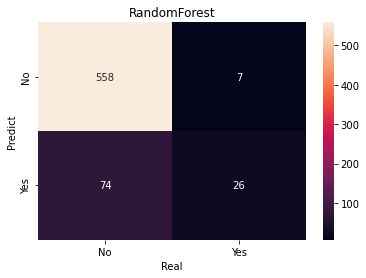

In [108]:
# evaluate the model
predprob = rf.predict_proba(X_test)
mod_eval(test_df, rf.predict(X_test),  y_test, 'RandomForest')

## Logistic Regression

In [109]:
# grid search for optimal hyperparameters
grid_values = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
               'solver':['liblinear'] # this is the only solver that allow parameters
              }

In [110]:
# grid search for optimal hyperparameters
model = LogisticRegression(max_iter=1000)
lr = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
lr.fit(X_train,y_train)
print(lr.best_params_)
print(lr.best_score_)

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.8704159319572659


              precision    recall  f1-score   support

           0       0.89      0.98      0.93       565
           1       0.70      0.32      0.44       100

    accuracy                           0.88       665
   macro avg       0.79      0.65      0.68       665
weighted avg       0.86      0.88      0.86       665



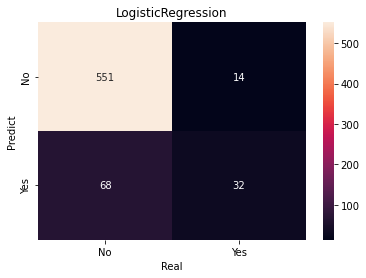

In [111]:
# evaluate the model
predprob = lr.predict_proba(X_test)
mod_eval(test_df, lr.predict(X_test), y_test, 'LogisticRegression') 

## NaiveBayes

              precision    recall  f1-score   support

           0       0.95      0.11      0.20       565
           1       0.16      0.97      0.28       100

    accuracy                           0.24       665
   macro avg       0.56      0.54      0.24       665
weighted avg       0.84      0.24      0.21       665



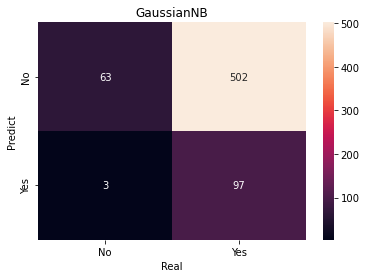

In [112]:
# there are no hyperparameters to gridsearch
gnb = GaussianNB()
gnb.fit(X_train, y_train)
mod_eval(test_df, gnb.predict(X_test),  y_test, 'GaussianNB')

## SVC

In [113]:
# grid search for optimal hyperparameters
grid_values = {'C': [1, 10],
              'gamma': [0.5, 0.7, 0.9, 0.95],
              'kernel':['linear','poly','rbf']
              }

In [114]:
# grid search for optimal hyperparameters
model = SVC(class_weight='balanced',probability=True)
svc = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
svc.fit(X_train,y_train)
print(svc.best_params_)
print(svc.best_score_)

{'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.8529986515921586


              precision    recall  f1-score   support

           0       0.87      0.97      0.92       565
           1       0.51      0.19      0.28       100

    accuracy                           0.85       665
   macro avg       0.69      0.58      0.60       665
weighted avg       0.82      0.85      0.82       665



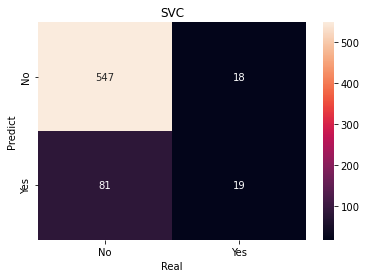

In [115]:
# evaluate
predprob = svc.predict_proba(X_test)
mod_eval(test_df,svc.predict(X_test), y_test, 'SVC')
plt.show()

## Adaboost

In [116]:
# grid search for optimal hyperparameters
grid_values = {'learning_rate': [1, 2, 3],
               'n_estimators':[50,100,150]}

In [117]:
# grid search for optimal hyperparameters
model = AdaBoostClassifier()
boost = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
boost.fit(X_train,y_train)
print(boost.best_params_)
print(boost.best_score_)

{'learning_rate': 1, 'n_estimators': 150}
0.8723597137226429


              precision    recall  f1-score   support

           0       0.90      0.95      0.93       565
           1       0.61      0.43      0.51       100

    accuracy                           0.87       665
   macro avg       0.76      0.69      0.72       665
weighted avg       0.86      0.87      0.86       665



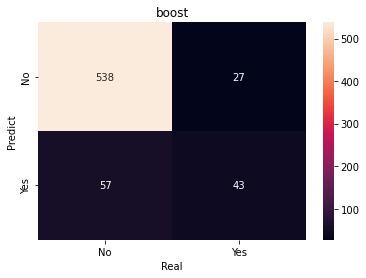

In [118]:
# evaluate the model
predprob = boost.predict_proba(X_test)
mod_eval(test_df,boost.predict(X_test),  y_test, 'boost')
plt.show()

## Compare Models

In [54]:
# compare final models: accuracy
import sklearn
accuracy_vals=[]
for val in [rf.predict(X_test),
lr.predict(X_test),
gnb.predict(X_test),
svc.predict(X_test),
boost.predict(X_test),      
           ]:
    accuracy_vals.append(sklearn.metrics.accuracy_score(val, y_test.values))
accuracy_vals

[0.8887218045112782,
 0.8736842105263158,
 0.849624060150376,
 0.8481203007518797,
 0.8556390977443609]

In [55]:
# compare final models: ROCAUC
roc_vals=[]
for val in [rf.predict(X_test),
            lr.predict(X_test),
            gnb.predict(X_test),
            svc.predict(X_test),
           boost.predict(X_test)]:
    roc_vals.append(sklearn.metrics.roc_auc_score(val, y_test.values))
roc_vals

[0.8453923290879812,
 0.7812214651963195,
 0.7064831261101243,
 0.676984126984127,
 0.7125649761935963]

In [56]:
# display final values
models = ['random forest', 'logistic regression', 'naive bayes', 'support vector', 'boosted']
evaldf = pd.DataFrame(list(zip(models, accuracy_vals, roc_vals)))
evaldf.columns=['model', 'accuracy', 'rocauc']
evaldf=evaldf.set_index('model', drop=True)
evaldf

,accuracy,rocauc
model,,
random forest,0.888722,0.845392
logistic regression,0.873684,0.781221
naive bayes,0.849624,0.706483
support vector,0.848120,0.676984
boosted,0.855639,0.712565


In [57]:
import plotly.graph_objects as go
# display results with plotly
trace0 = go.Bar(x= evaldf.index,
                y= evaldf['accuracy'].values,
                name='accuracy',
                marker=dict(color='rgb(100,200,300)'))
trace1 = go.Bar(x= evaldf.index,
                y= evaldf['rocauc'].values,
                name='roc-auc',
                marker=dict(color='rgb(300,200,100)'))
# now the layout
layout=go.Layout(title='Model Comparison',
                   xaxis= dict(title='Model'),
                   yaxis=dict(title='Score'))
# bind using go.Figure
fig = go.Figure(data=[trace0, trace1], layout=layout)
fig

In [58]:
# true positives, etc.
y_score = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresh=roc_curve(y_test, y_score)
roc_df=pd.DataFrame(zip(fpr, tpr, thresh), columns=['FPR','TPR','Threshold'])
roc_df.head()

,FPR,TPR,Threshold
0,0.00000,0.00,1.900000
1,0.00000,0.01,0.900000
2,0.00000,0.02,0.880000
3,0.00177,0.02,0.859522
4,0.00177,0.03,0.840000


In [59]:
import plotly.express as px

def make_rocauc(i):
    nearest=roc_df.iloc[(roc_df['Threshold']-i).abs().argsort()[:1]]['Threshold'].values[0]
    q=roc_df[roc_df['Threshold']==nearest].index[0]
    print(nearest, q)
    fig = px.area(roc_df, x="FPR", y="TPR",
                  title=f'ROC Curve (AUC={auc(fpr, tpr):.3f})',
                  hover_data={'Threshold':':.2f',
                              'FPR':':.2f',
                              'TPR':':.2f',
                             },width=800, height=700)

    fig.add_annotation(x=roc_df.iloc[q][0], y=roc_df.iloc[q][1],
            text=f"Threshold nearest {i*100:.0f}% = {roc_df.iloc[q][2]:.2f}",
                showarrow=True,
                arrowhead=1)

    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    return fig

In [60]:
# choose a threshold for prediction.
make_rocauc(.60)

0.5985230866540164 14


Final Results

In [61]:
# Random Forest feature importance
fi_df = pd.DataFrame({'fi': rf.best_estimator_.feature_importances_},index=X_train.columns).sort_values(by='fi', ascending=False)
fi_df

,fi
ln_Recency,0.131404
ln_Spending,0.121805
ln_Income,0.115764
ln_age,0.079876
ln_catalog,0.071192
ln_store,0.065145
ln_visits,0.063737
AcceptedCmp5,0.058893
ln_web,0.054679
ln_deals,0.045951


In [62]:
list(test_df.columns)

['Kidhome',
 'Teenhome',
 'AcceptedCmp5',
 'Response',
 'Education_Graduation',
 'Education_PhD',
 'Education_Master',
 'Education_Unknown',
 'Education_Basic',
 'Marital_Status_Married',
 'Marital_Status_Together',
 'Marital_Status_Single',
 'Marital_Status_Divorced',
 'Marital_Status_Widow',
 'Marital_Status_Unknown',
 'ln_age',
 'ln_Income',
 'ln_Recency',
 'ln_Spending',
 'ln_Yrs_Customer',
 'ln_deals',
 'ln_web',
 'ln_catalog',
 'ln_store',
 'ln_visits']

In [63]:
# display results with plotly
trace0 = go.Bar(x= fi_df.index,
                y= fi_df['fi'].values,
                marker=dict(color='rgb(100,200,300)'))

# now the layout
layout=go.Layout(title='Feature Importance',
                   xaxis= dict(title='Feature'),
                   yaxis=dict(title='Score'))
# bind using go.Figure
fig = go.Figure(data=[trace0], layout=layout)
fig

In [64]:
# what are the key variables like?
X_test[['ln_Recency', 'ln_Income', 'ln_Spending', 'ln_age', 'AcceptedCmp5']].sample(3).T

,1830,1438,462
ln_Recency,-0.702142,-2.532710,0.036145
ln_Income,-0.873460,0.758543,0.571767
ln_Spending,-0.929327,0.931690,0.854529
ln_age,-2.090684,0.098028,1.049601
AcceptedCmp5,0.000000,0.000000,0.000000


## Pickle model and preprocessing steps

In [65]:
# save the dataframes for visualization
responded.to_csv('../model_components/cust_responded.csv', index=False)
ignored.to_csv('../model_components/cust_ignored.csv', index=False)

In [66]:
# pickle your random forest model
filename = open('../model_components/cust_response_rf_model.pkl', 'wb')
pickle.dump(rf, filename)
filename.close()

In [67]:
# encoder1
filename = open('../model_components/cust_response_edu_onehot_encoder.pkl', 'wb')
pickle.dump(encoder1, filename)
filename.close()

In [68]:
# encoder2
filename = open('../model_components/cust_response_marital_onehot_encoder.pkl', 'wb')
pickle.dump(encoder2, filename)
filename.close()

In [69]:

filename = open('../model_components/age_ss_scaler.pkl', 'wb')
pickle.dump(ss_scaler0, filename)
filename.close()

filename = open('../model_components/income_ss_scaler.pkl', 'wb')
pickle.dump(ss_scaler1, filename)
filename.close()

filename = open('../model_components/recency_ss_scaler.pkl', 'wb')
pickle.dump(ss_scaler2, filename)
filename.close()

filename = open('../model_components/spend_ss_scaler.pkl', 'wb')
pickle.dump(ss_scaler3, filename)
filename.close()

filename = open('../model_components/yrs_cust_ss_scaler.pkl', 'wb')
pickle.dump(ss_scaler30, filename)
filename.close()



In [70]:

filename = open('../model_components/deals_ss_scaler.pkl', 'wb')
pickle.dump(ss_scaler4, filename)
filename.close()

filename = open('../model_components/web_ss_scaler.pkl', 'wb')
pickle.dump(ss_scaler40, filename)
filename.close()

filename = open('../model_components/catalog_ss_scaler.pkl', 'wb')
pickle.dump(ss_scaler41, filename)
filename.close()

filename = open('../model_components/store_ss_scaler.pkl', 'wb')
pickle.dump(ss_scaler42, filename)
filename.close()

filename = open('../model_components/visits_ss_scaler.pkl', 'wb')
pickle.dump(ss_scaler43, filename)
filename.close()
